# Phase 2 Project
- Student: Jonathan Holt
- DS Flex

## The Problem

Trailblazer Renovations is a home contractor that specializes in home additions and renovations. They are based in Northern California, but have been getting requests from homeowners in Washington State. They are interested in expanding their business, but want to gauge the situation before diving in.

They have already decided to focus their efforts on King County Washington as it contains a large population of people (including metropolitan Seattle) and could be a good opportunity for growth for them.

I have been tasked with analyzing home prices in King County to determine where the market for home renovations lies so that Trailblazer can meet that need. Part of this analysis is to determine which renovation types have the biggest increase in home value so that those services can be the focus of their marketing campaign.

While they plan on marketing to all of King County, they want to know if there are any particular areas that they should focus a greater portion of their energy in marketing to.

## The Data

I have the king county dataset which gives information on home values in King County.
I have also found information clarifying what the different building grade and condition types are from the King County government website.

<u>source: Data/column_names.md</u>

<b>Here is what is contained in the raw data:</b>

* **id** - unique identified for a house
* **date** - house was sold
* **price** -  is prediction target
* **bedrooms** -  of Bedrooms/House
* **bathrooms** -  of bathrooms/bedrooms
* **sqft_livings** -  footage of the home
* **sqft_lots** -  footage of the lot
* **floors** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

## Glossary
- additional information about the Data that I have

### Building Condition Explaination
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#d (accessed 12/6/2021)

Relative to age and grade. Coded 1-5.

<b>1) Poor:</b>
- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

<b>2) Fair:</b>
- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

<b>3) Average:</b>
- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

<b>4) Good:</b> 
- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

<b>5) Very Good:</b>
- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.


### Building Grade Explanation
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#d (accessed 12/6/2021)


Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

<b>1-3:</b>  Falls short of minimum building standards. Normally cabin or inferior structure.

<b>4:</b>  Generally older, low quality construction. Does not meet code.

<b>5:</b>  Low construction costs and workmanship. Small, simple design.

<b>6:</b>  Lowest grade currently meeting building code. Low quality materials and simple designs.

<b>7:</b>  Average grade of construction and design. Commonly seen in plats and older sub-divisions.

<b>8:</b>  Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

<b>9:</b>  Better architectural design with extra interior and exterior design and quality.

<b>10:</b>  Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

<b>11:</b>  Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

<b>12:</b>  Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

<b>13:</b>  Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

## Questions to Answer

1. What features have the biggest effect on home price?
2. Are these features able to be changed/renovated, or are they fixed?
3. What are the best features that Trailblazer should market to potential clients?
4. Who should Trailblazer target their marketing campaign toward?
5. Are there any features that I recommend against? 

# Data Preparation

## Importing Data & Settings

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', 1000) #change the amount of rows displayed
plt.style.use('seaborn')

#function for displaying money in millions.
def display_millions(x, pos):
    return '${:1.1f}M'.format(x*1e-6)

#function for displaying money in thousands.
def display_thousands(x, pos):
    return '${:1.1f}K'.format(x*1e-3)

df = pd.read_csv('Data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Dropping Uncessary Columns
- Looking at the column descriptions, I have determined that several are unecessary.
- Of course, if I find that I need any of them, I can easily get them back into the dataset.

In [2]:
df = df.drop(df[['id','date', 'view', 'lat', 'long', 'yr_renovated']], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,98074,1800,7503


## Checking Data Types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     19221 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  zipcode        21597 non-null  int64  
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.5+ MB


**Analysis:**
- waterfront seems to have Null Values
- sqft_basement is an object and will need to be converted to float or integer.

### Fixing Waterfront

In [4]:
waterfront_cleaned = df['waterfront'].fillna(0) 
df['waterfront'] = waterfront_cleaned
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
sqft_living15    0
sqft_lot15       0
dtype: int64

### Fixing sqft_basement
- slicing out all records with a '?' and calculating the correct value using other known fields.

In [5]:
unknown_basements = df[df['sqft_basement'] == '?']
known_basements = df[df['sqft_basement'] != '?']

sqft_basement = unknown_basements.apply(lambda x: x['sqft_living'] - x['sqft_above'], axis=1)
unknown_basements['sqft_basement'] = sqft_basement

cleaned_df = known_basements.append(unknown_basements)

#changing to float so that decminals are in the same format
cleaned_df['sqft_basement'] = cleaned_df['sqft_basement'].astype(float)
cleaned_df['sqft_above'] = cleaned_df['sqft_above'].astype(float)

cleaned_df['sqft_basement'].value_counts().head()


<ipython-input-5-177a306978bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_basements['sqft_basement'] = sqft_basement


0.0      13110
600.0      221
700.0      218
500.0      214
800.0      206
Name: sqft_basement, dtype: int64

### Changing Zip Code to Category

In [6]:
cleaned_df['zipcode'] = df['zipcode'].astype(str)
cleaned_df['zipcode'].value_counts().head()

98103    602
98038    589
98115    583
98052    574
98117    553
Name: zipcode, dtype: int64

### Dropping Bedroom Outliers

In [7]:
cleaned_df['bedrooms'].value_counts().head(20)

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [8]:
cleaned_df.sort_values('bedrooms', ascending=False).head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
15856,640000.0,33,1.75,1620,6000,1.0,0.0,5,7,1040.0,580.0,1947,98103,1330,4700
8748,520000.0,11,3.00,3000,4960,2.0,0.0,3,7,2400.0,600.0,1918,98106,1420,4960
15147,650000.0,10,2.00,3610,11914,2.0,0.0,4,7,3010.0,600.0,1958,98006,2040,11914
19239,660000.0,10,3.00,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1913,98105,1810,3745
13301,1150000.0,10,5.25,4590,10920,1.0,0.0,3,9,2500.0,2090.0,2008,98004,2730,10400
8537,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,4050.0,0.0,1996,98144,1448,3866
18428,934000.0,9,3.00,2820,4480,2.0,0.0,3,7,1880.0,940.0,1918,98105,2460,4400
4231,700000.0,9,3.00,3680,4400,2.0,0.0,3,7,2830.0,850.0,1908,98102,1960,2450
16830,1400000.0,9,4.00,4620,5508,2.5,0.0,3,11,3870.0,750.0,1915,98105,2710,4320
6073,1280000.0,9,4.50,3650,5000,2.0,0.0,3,8,2530.0,1120.0,1915,98105,2510,5000


I doubt that any house has 33 bedrooms. It is likely a typo. I will also drop the records with 10 and 11 bedrooms to remove some of the extreme outliers. This will only be 5 records and have very minimal impact on my data.

In [9]:
#dropping outliers
cleaned_df = cleaned_df.sort_values('bedrooms', ascending=False).reset_index()
cleaned_df = cleaned_df.drop([0,1,2,3,4,5])
cleaned_df.head(5)

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
6,18428,934000.0,9,3.0,2820,4480,2.0,0.0,3,7,1880.0,940.0,1918,98105,2460,4400
7,4231,700000.0,9,3.0,3680,4400,2.0,0.0,3,7,2830.0,850.0,1908,98102,1960,2450
8,16830,1400000.0,9,4.0,4620,5508,2.5,0.0,3,11,3870.0,750.0,1915,98105,2710,4320
9,6073,1280000.0,9,4.5,3650,5000,2.0,0.0,3,8,2530.0,1120.0,1915,98105,2510,5000
10,4092,599999.0,9,4.5,3830,6988,2.5,0.0,3,7,2450.0,1380.0,1938,98103,1460,6291


In [10]:
#dropping index
cleaned_df = cleaned_df.drop(['index'], axis=1)

In [11]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21591 entries, 6 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21591 non-null  float64
 1   bedrooms       21591 non-null  int64  
 2   bathrooms      21591 non-null  float64
 3   sqft_living    21591 non-null  int64  
 4   sqft_lot       21591 non-null  int64  
 5   floors         21591 non-null  float64
 6   waterfront     21591 non-null  float64
 7   condition      21591 non-null  int64  
 8   grade          21591 non-null  int64  
 9   sqft_above     21591 non-null  float64
 10  sqft_basement  21591 non-null  float64
 11  yr_built       21591 non-null  int64  
 12  zipcode        21591 non-null  object 
 13  sqft_living15  21591 non-null  int64  
 14  sqft_lot15     21591 non-null  int64  
dtypes: float64(6), int64(8), object(1)
memory usage: 2.6+ MB


- The only object that is left is zipcode, which is correct. I don't want this to be considered a continuous variable. I will one-hot-encode it when I get to that step.

# Exploratory Data Analysis & Feature Selection

## Exploring Data with Scatter Plot

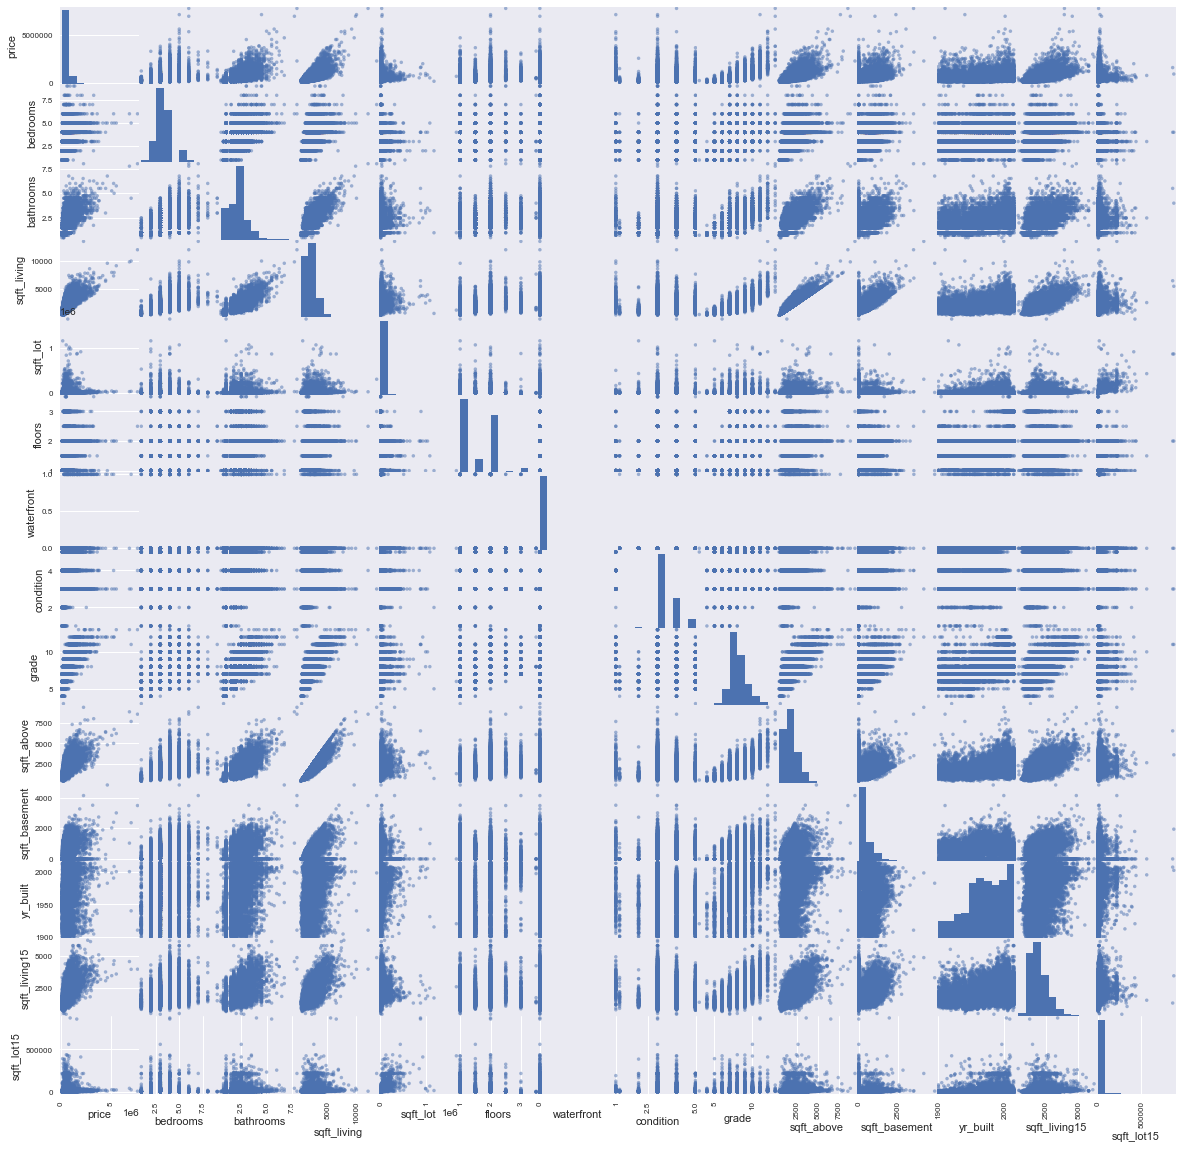

In [12]:
#using scatter plot to look for linear relationships
pd.plotting.scatter_matrix(cleaned_df, figsize = [20,20]);
plt.show()

**Analysis of Scatter Plots**

<u>The following variables seem to have linear relationships:</u>
- **Price:**  linear relationship with: bedrooms, sqft_above, & sqft_basement.
    - price also seems to have a linear relationship with categorical variable 'grade'.
- **Bedrooms** linear relationship with: bathrooms, sqft_living, sqft_above, & sqft_basement
- **Sqft_Living and Sqft_Above have the closest linear relationship**
    - They are very similar data points. I may need to eliminate one to prevent multicolinearity.
    
<u>The Following Variables seem to be categorical:</u>
- **Floors**
- **Waterfront**
- **Condition**
- **Zip code** (not shown in this scatter plot because it is an object)


<u>Ordinal Variables:</u>
- **Bedrooms**
- **Bathrooms**
- **Grade** (I am going to treat grade as a continuous variable as it has very linear relationships with many features. Including price.)

## Histograms Comparing Price and Features
- each feature is compared against price. (Price is y axis)

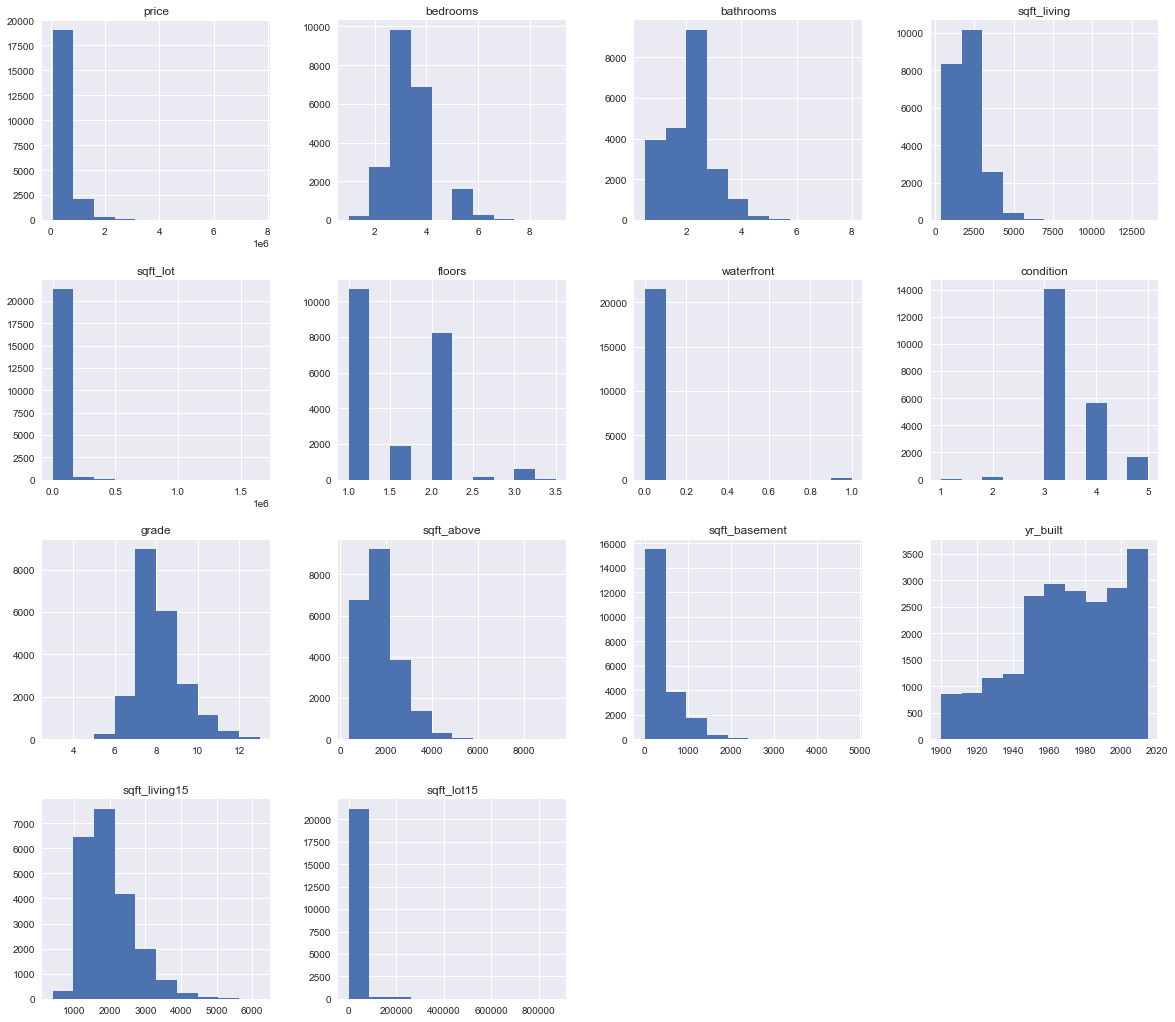

In [13]:
cleaned_df.hist(figsize = (20,18));

**Analysis of Histograms:**
- Price is very skewed. I will need to fix this as it is my target variable.
- Lot size (sqft_lot and sqft_lot15) seem to be consistant across the board. Especially when compared to the variation in house size (sqft_living, sqft_above, sqft_living15).
- The vast majority of homes have a condition of 3, which is the middle value of "average". This column isn't giving me much information so it should probably be dropped.

## Analysis of key variables against the Target (price) using jointplots

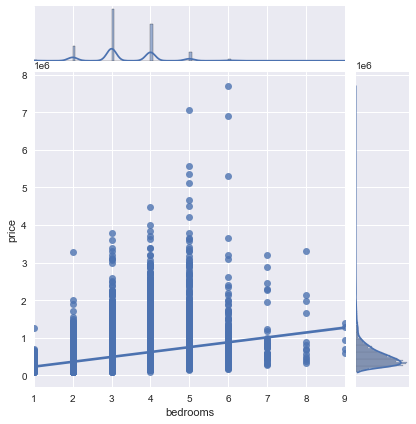

In [14]:
sns.jointplot('bedrooms','price', data=cleaned_df, kind='reg');

<u>**Bedrooms**</u>: While this is an ordinal variable, it behaves more like a categorical than a continuous variable. 
7 bedrooms isn't necessarily better than 2 bedrooms, it all depends on the house itself. That said, there is a slight linear relationship. I may try both methods to see which way this feature will best fit my model.

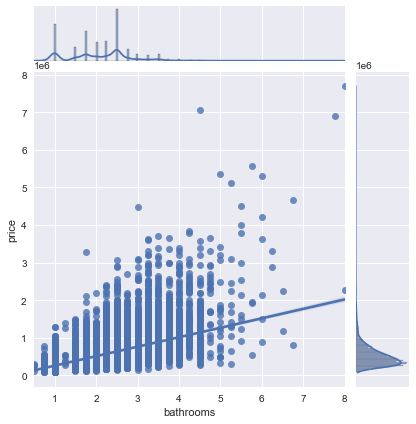

In [15]:
sns.jointplot('bathrooms','price', data=cleaned_df, kind='reg');

<u>**Bathroooms**</u>: Unlike bedrooms, bathrooms behave more like a continous variable than a categorical one, so I will treat it as such. This also means that it will be a better predictor than bedrooms. If I have to chose between one or the other, I should choose bathrooms. This is likely because the scatterplot showed them to have a very linear relationship with each other.

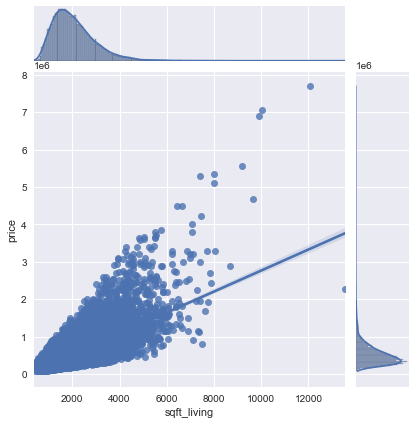

In [16]:
sns.jointplot('sqft_living','price', data=cleaned_df, kind='reg');

<u>**Sqft_living**</u>: This seems to be a very linear relationship. This makes sense as the bigger the house it, the more likely that it costs more.

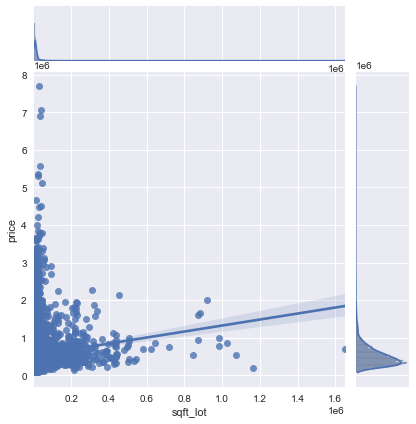

In [17]:
sns.jointplot('sqft_lot','price', data=cleaned_df, kind='reg');

<u>**sqft_lot**</u>: Lot size has a slight correlation with the price of a house, but there are a lot of outliers, especially with little to no lot size. It will be hard to use this as a predictor.

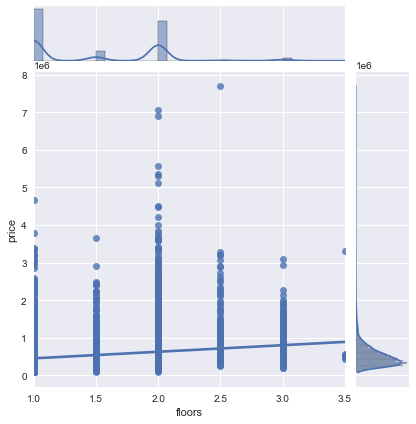

In [18]:
sns.jointplot('floors','price', data=cleaned_df, kind='reg');


<u>**Floors**</u>: There is almost no correlation with price, so this feature can likely be excluded from my model.

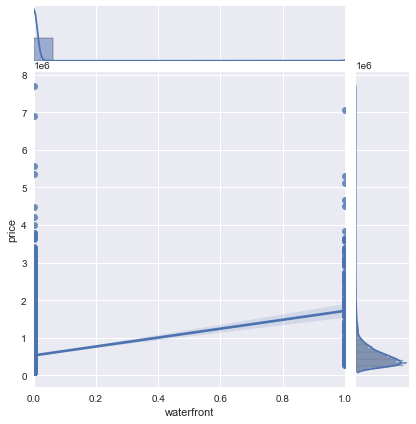

In [19]:
sns.jointplot('waterfront','price', data=cleaned_df, kind='reg');

<u>**Waterfront**</u>: There appears to be a slight linear relationship between price and being on the waterfront. There are very few houses in this dataset that are on the waterfront, but this feature may still affect the price and should be left in unless it causes issues. 

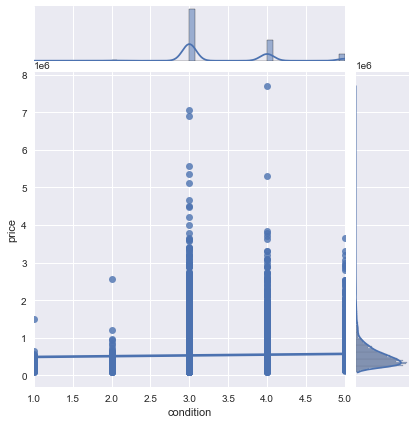

In [20]:
sns.jointplot('condition','price', data=cleaned_df, kind='reg');

<u>**Condition**</u>: As noted in the analysis of the scatter plot, condition doesn't have much of an affect on price. I can drop this feature.

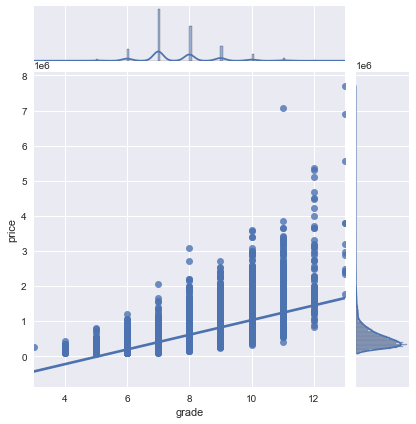

In [21]:
sns.jointplot('grade','price', data=cleaned_df, kind='reg');

<u>**Grade**</u>: Grade has a slightly linear relationship with a little noise. I should keep it as a continous variable. The relationship looks like it could be improved with some cleaning, removing outliers, etc.

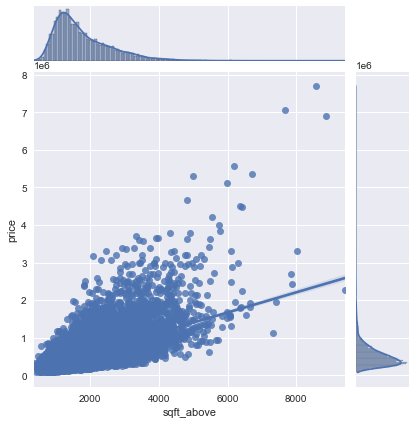

In [22]:
sns.jointplot('sqft_above','price', data=cleaned_df, kind='reg');

<u>**Sqft_Above**</u>: This feature is almost exactly the same thing as sqft_living. (Scatter plot supports this, as well as their glossary descriptions being very similar). I will almost definitely need to remove one of the two of these variables and use the other due to multicolinearity. I will determine which to use when I check for that.

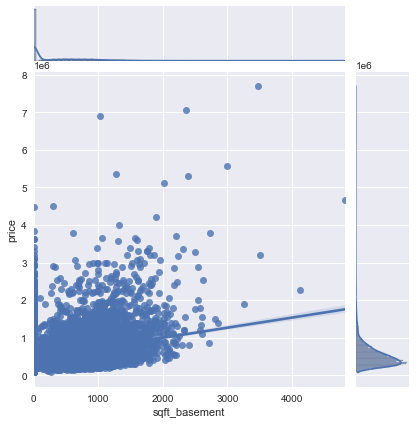

In [23]:
sns.jointplot('sqft_basement','price', data=cleaned_df, kind='reg');

<u>**Basement**</u>: Basement size has a slight linear relationship with price. But I also see that there are many outliers that have very little size that are skewing the results. If I can deal with them. it could improve the prediction power of this feature.

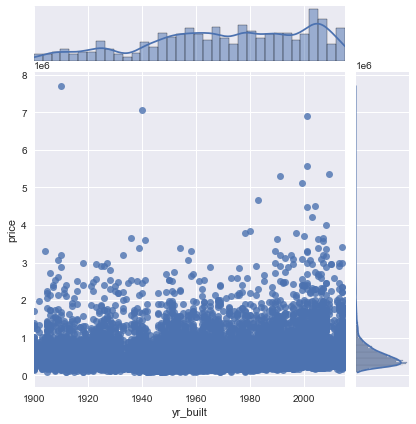

In [24]:
sns.jointplot('yr_built','price', data=cleaned_df, kind='reg');

<u>**Year Built**</u>: The year each house was built seems to have no relationship with Price and can likely be excluded from my model.

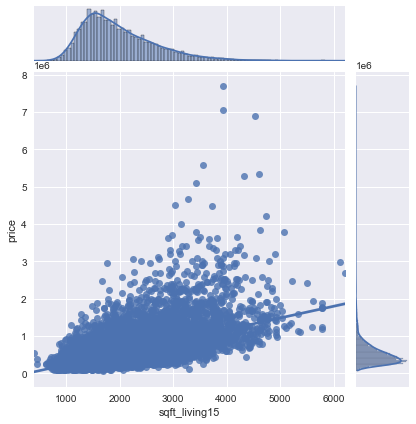

In [25]:
sns.jointplot('sqft_living15','price', data=cleaned_df, kind='reg');

<u>**sqft_living15**</u>: The size of houses nearby does have a linear relationship with price. Looks fairly close to sqft_living and sqft_above so there's a strong chance of multicolinearity here as well.

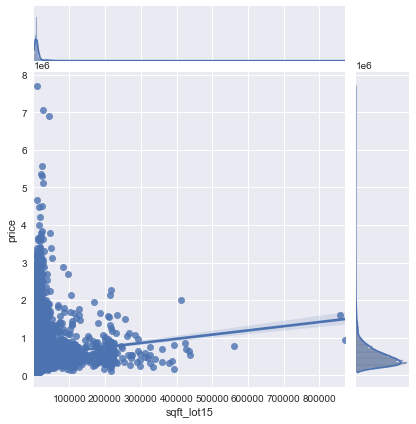

In [26]:
sns.jointplot('sqft_lot15','price', data=cleaned_df, kind='reg');

<u>**sqft_lot15**</u>: Looks identical to sqft_lot, which I likely won't end up using. This will likely be dropped as well. If I use either, it would be just that one as they are very likely to be multicolinear.

## Feature Selection
- sqft_living15 and sqft_lot15 give the same information as sqft_living and sqft_lot, so I will drop them to avoid multicolinearity.
- yr_built and condition didn't have a linear relationships with price, so I am not including them in my model.

**Dropping Columns**

In [27]:
cleaned_df = cleaned_df.drop(['sqft_living15', 'yr_built', 'sqft_lot15', 'condition'], axis=1)
cleaned_df.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode
6,934000.0,9,3.0,2820,4480,2.0,0.0,7,1880.0,940.0,98105


# Initial Modeling 

In [28]:
list(cleaned_df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'grade',
 'sqft_above',
 'sqft_basement',
 'zipcode']

In [29]:
# Defining the problem
outcome = 'price'
x_cols = list(cleaned_df.columns)
x_cols.remove(outcome)

train, test = train_test_split(cleaned_df, random_state=23)

print(len(train), len(test))

16193 5398


In [30]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     776.1
Date:                Wed, 22 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:48:22   Log-Likelihood:            -2.1793e+05
No. Observations:               16193   AIC:                         4.360e+05
Df Residuals:                   16115   BIC:                         4.366e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.713e+05   1.64e+04    -22.698      0.000   -4.03e+05   -3.39e+05
zipcode[T.98002]  4.644e+04   1.74e+04      2.670      0.008    1.23e+04    8.05e+04
zipcode[T.98003] -1.362e+04   1.56e+04     -0.873      0.383   -4.42e+04     1.7e+04
zipcode[T.98004]  7.938e+05   1.54e+04     51.424      0.000    7.64e+05    8.24e+05
zipcode[T.98005]  3.138e+05   1.83e+04     17.186      0.000    2.78e+05     3.5e+05
zipcode[T.98006]  2.956e+05   1.38e+04     21.481      0.000    2.69e+05    3.23e+05
zipcode[T.98007]  2.511e+05   1.95e+04     12.896      0.000    2.13e+05    2.89e+05
zipcode[T.98008]  2.677e+05   1.56e+04     17.169      0.000    2.37e+05    2.98e+05
zipcode[T.98010]  6.412e+04   2.27e+04      2.828      0.005    1.97e+04    1.09e+05
zipcode[T.98011]  1.109e+05    1.7e+04      6.512      0.000    7.75e+04    1.44e+05
zipcode[T.98014]  8.456e+04   2.07e+04      4.082      0.000     4.4e+04    1.25e+05
zipcode[T.98019]  7.083e+04   1.73e+04      4.100      0.000     3.7e+04    1.05e+05
zipcode[T.98022]  1.627e+04   1.68e+04      0.967      0.334   -1.67e+04    4.93e+04
zipcode[T.98023] -3.079e+04   1.35e+04     -2.281      0.023   -5.72e+04   -4334.544
zipcode[T.98024]  1.717e+05   2.45e+04      7.018      0.000    1.24e+05     2.2e+05
zipcode[T.98027]  1.586e+05   1.44e+04     11.020      0.000     1.3e+05    1.87e+05
zipcode[T.98028]  1.131e+05   1.55e+04      7.284      0.000    8.26e+04    1.43e+05
zipcode[T.98029]  2.102e+05   1.53e+04     13.745      0.000     1.8e+05     2.4e+05
zipcode[T.98030]  2956.0725    1.6e+04      0.185      0.853   -2.84e+04    3.43e+04
zipcode[T.98031]  9366.6603   1.57e+04      0.597      0.551   -2.14e+04    4.01e+04
zipcode[T.98032]  2.165e+04   2.08e+04      1.039      0.299   -1.92e+04    6.25e+04
zipcode[T.98033]  3.848e+05   1.39e+04     27.583      0.000    3.57e+05    4.12e+05
zipcode[T.98034]  2.037e+05   1.33e+04     15.303      0.000    1.78e+05     2.3e+05
zipcode[T.98038]  1.987e+04    1.3e+04      1.526      0.127   -5658.082    4.54e+04
zipcode[T.98039]  1.304e+06   3.07e+04     42.498      0.000    1.24e+06    1.36e+06
zipcode[T.98040]   5.55e+05   1.56e+04     35.517      0.000    5.24e+05    5.86e+05
zipcode[T.98042]  6181.8254   1.32e+04      0.467      0.640   -1.97e+04    3.21e+04
zipcode[T.98045]  9.261e+04   1.65e+04      5.608      0.000    6.02e+04    1.25e+05
zipcode[T.98052]  2.192e+05   1.33e+04     16.470      0.000    1.93e+05    2.45e+05
zipcode[T.98053]  1.644e+05   1.42e+04     11.555      0.000    1.36e+05    1.92e+05
zipcode[T.98055]  5.573e+04   1.58e+04      3.525      0.000    2.47e+04    8.67e+04
zipcode[T.98056]  1.121e+05   1.42e+04      7.878      0.000    8.42e+04     1.4e+05
zipcode[T.98058]  2.568e+04   1.39e+04      1.851      0.064   -1511.155    5.29e+04
zipcode[T.98059]  7.844

## Analysis of First Model:
- The R-squared is 78.8%, which is really good. My data cleaning and feature selection must have paid off.
- That said, I'm sure further refinement will be necessary.
- There are high p-values on several of the zipcodes.
- Skew is higher than I would like it to be.
- Kurtosis is also very high.

# Refining My Model

## Cleaning & Encoding

In [31]:
encoded_df= cleaned_df

In [32]:
#cleaning columns so that I can One-Hot Encode them
subs = [(' ', '_'),('.',''),("'",""),
        ('+','plus'), ('-','_')]

def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

In [33]:
encoded_df.columns = [col_formatting(col) for col in encoded_df.columns]

In [34]:
list(encoded_df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'grade',
 'sqft_above',
 'sqft_basement',
 'zipcode']

In [35]:
#one-hot encoding
feats = ['floors', 'waterfront','zipcode'] #treating bedrooms as a continous variable helps the model
encoded_df[feats] = encoded_df[feats].astype(str)
encoded_df = pd.get_dummies(encoded_df, drop_first=True)

In [36]:
encoded_df.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,floors_1.5,floors_2.0,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
6,934000.0,9,3.0,2820,4480,7,1880.0,940.0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [37]:
encoded_df.columns = [col_formatting(col) for col in encoded_df.columns]

### Normalizing Data

In [38]:
def norm_feat(series):
    return (series - series.mean())/series.std()

In [39]:
df_norm = norm_feat(encoded_df)
df_norm.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,floors_15,floors_20,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
6,1.071718,6.26552,1.152054,0.806230,-0.256447,-0.560824,0.110668,1.465326,-0.311518,1.273992,...,-0.116269,-0.051448,-0.145229,-0.109104,-0.112319,-0.109321,-0.110829,-0.079615,-0.114622,-0.122066
7,0.434798,6.26552,1.152054,1.743178,-0.258379,-0.560824,1.258497,1.261941,-0.311518,1.273992,...,-0.116269,-0.051448,-0.145229,-0.109104,-0.112319,-0.109321,-0.110829,-0.079615,-0.114622,-0.122066
8,2.340115,6.26552,2.454359,2.767284,-0.231627,2.848409,2.515068,1.035958,-0.311518,-0.784898,...,-0.116269,-0.051448,-0.145229,-0.109104,-0.112319,-0.109321,-0.110829,-0.079615,-0.114622,-0.122066
9,2.013489,6.26552,3.105511,1.710494,-0.243892,0.291485,0.896025,1.872096,-0.311518,1.273992,...,-0.116269,-0.051448,-0.145229,-0.109104,-0.112319,-0.109321,-0.110829,-0.079615,-0.114622,-0.122066
10,0.162607,6.26552,3.105511,1.906599,-0.195894,-0.560824,0.799365,2.459653,-0.311518,-0.784898,...,-0.116269,-0.051448,-0.145229,-0.109104,-0.112319,-0.109321,-0.110829,-0.079615,-0.114622,-0.122066


### Checking Multicolinearity with VIF scores

In [40]:
x_cols = list(df_norm.columns)
x_cols.remove(outcome)
X = df_norm[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


[('bedrooms', 1.762884316470203),
 ('bathrooms', 3.1354539328330007),
 ('sqft_living', inf),
 ('sqft_lot', 1.2180483564649132),
 ('grade', 3.2803657450221477),
 ('sqft_above', inf),
 ('sqft_basement', inf),
 ('floors_15', 1.2702746143368044),
 ('floors_20', 2.429082325023472),
 ('floors_25', 1.1033907900598452),
 ('floors_30', 1.3520102111574994),
 ('floors_35', 1.007850756007571),
 ('waterfront_10', 1.0615885226056663),
 ('zipcode_98002', 1.5411528708335134),
 ('zipcode_98003', 1.756711400703128),
 ('zipcode_98004', 1.8879939883720351),
 ('zipcode_98005', 1.4733139631279435),
 ('zipcode_98006', 2.390836236858363),
 ('zipcode_98007', 1.3874215323839338),
 ('zipcode_98008', 1.775740846271686),
 ('zipcode_98010', 1.2777745114206935),
 ('zipcode_98011', 1.5291035510375375),
 ('zipcode_98014', 1.365439019203317),
 ('zipcode_98019', 1.5221944675217256),
 ('zipcode_98022', 1.656617683589679),
 ('zipcode_98023', 2.3341104209902643),
 ('zipcode_98024', 1.2382682579358484),
 ('zipcode_98027', 2

### Analysis:
- sqft_living, sqft_above, and sqft_basement all have infinite VIF scores.
- sqft_living or sqft_above will definitely need to be dropped. I will check for colinear pairs to see if one is causing more problems than the other.
- The other VIF scores are acceptable.

###  Finding Colinear Pairs

In [41]:
cc_df = df_norm.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.70) & (cc_df.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.876477
"(sqft_living, grade)",0.763120
"(sqft_above, grade)",0.756391
"(bathrooms, sqft_living)",0.755941
"(sqft_living, price)",0.702029


**Analysis:**
- sqft_living is causing more problems than sqft_above. My data analysis thus far has shown them to be incredibly similar so I will be fine keeping just one of them. 
- Grade is highly correlated to sqft_above, but I will initially leave it in my model and see what it looks like. I don't want to remove too many features if I can keep them.

In [42]:
df_norm = df_norm.drop(['sqft_living'], axis=1)
df_norm.head(1)

,price,bedrooms,bathrooms,sqft_lot,grade,sqft_above,sqft_basement,floors_15,floors_20,floors_25,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
6,1.071718,6.26552,1.152054,-0.256447,-0.560824,0.110668,1.465326,-0.311518,1.273992,-0.086675,...,-0.116269,-0.051448,-0.145229,-0.109104,-0.112319,-0.109321,-0.110829,-0.079615,-0.114622,-0.122066


In [43]:
cc_df = df_norm.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.70) & (cc_df.cc<1)]

,cc
pairs,
"(grade, sqft_above)",0.756391


That took care of most of the correlated pairs. Now let's check the vif scores again and see if it resolved the infinite correlations.

In [44]:
x_cols = list(df_norm.columns)
x_cols.remove(outcome)
X = df_norm[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 1.7681469134950174),
 ('bathrooms', 3.136291868974238),
 ('sqft_lot', 1.2180499054745253),
 ('grade', 3.28053119354771),
 ('sqft_above', 4.4797511573497015),
 ('sqft_basement', 1.9155359304596866),
 ('floors_15', 1.270277097802257),
 ('floors_20', 2.429535579553982),
 ('floors_25', 1.1039585166717556),
 ('floors_30', 1.352020550898107),
 ('floors_35', 1.007879305695572),
 ('waterfront_10', 1.0615894361516676),
 ('zipcode_98002', 1.5411536516400872),
 ('zipcode_98003', 1.7567114745952686),
 ('zipcode_98004', 1.887994996695563),
 ('zipcode_98005', 1.4733143253648087),
 ('zipcode_98006', 2.3908372609955353),
 ('zipcode_98007', 1.387421811892771),
 ('zipcode_98008', 1.775742402426752),
 ('zipcode_98010', 1.2777752468620431),
 ('zipcode_98011', 1.5291037780357966),
 ('zipcode_98014', 1.365439728227529),
 ('zipcode_98019', 1.5221948549989457),
 ('zipcode_98022', 1.6566188371131427),
 ('zipcode_98023', 2.3341107187647023),
 ('zipcode_98024', 1.2382698301740895),
 ('zipcode_98027

I am happy with these VIF scores. My target variable (price) still has a decent correlation with sqft_above, grade and bathrooms, but they are within the limits that I have (VIF < 7), and they are predictors that I want to keep if at all possible.

### Running the model again

In [45]:
# Defining the problem
outcome = 'price'
x_cols = list(df_norm.columns)
x_cols.remove(outcome)
train, test = train_test_split(df_norm, random_state=23)
print(len(train), len(test))

16193 5398


In [46]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     745.4
Date:                Wed, 22 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:52:32   Log-Likelihood:                -10365.
No. Observations:               16193   AIC:                         2.089e+04
Df Residuals:                   16111   BIC:                         2.152e+04
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0022      0.004     -0.600      0.549      -0.009       0.005
bedrooms         -0.0837      0.005    -17.323      0.000      -0.093      -0.074
bathrooms         0.0399      0.006      6.231      0.000       0.027       0.052
sqft_lot          0.0265      0.004      6.726      0.000       0.019       0.034
grade             0.1761      0.007     26.922      0.000       0.163       0.189
sqft_above        0.5245      0.008     68.847      0.000       0.510       0.539
sqft_basement     0.2015      0.005     40.047      0.000       0.192       0.211
floors_15        -0.0078      0.004     -1.898      0.058      -0.016       0.000
floors_20        -0.1042      0.006    -18.477      0.000      -0.115      -0.093
floors_25         0.0117      0.004      3.046      0.002       0.004       0.019
floors_30        -0.0587      0.004    -13.914      0.000      -0.067      -0.050
floors_35        -0.0093      0.004     -2.509      0.012      -0.017      -0.002
waterfront_10     0.2008      0.004     55.428      0.000       0.194       0.208
zipcode_98002     0.0119      0.005      2.640      0.008       0.003       0.021
zipcode_98003    -0.0041      0.005     -0.851      0.395      -0.013       0.005
zipcode_98004     0.2594      0.005     51.573      0.000       0.250       0.269
zipcode_98005     0.0744      0.004     17.084      0.000       0.066       0.083
zipcode_98006     0.1212      0.006     21.665      0.000       0.110       0.132
zipcode_98007     0.0550      0.004     12.929      0.000       0.047       0.063
zipcode_98008     0.0826      0.005     17.163      0.000       0.073       0.092
zipcode_98010     0.0111      0.004      2.670      0.008       0.003       0.019
zipcode_98011     0.0289      0.004      6.626      0.000       0.020       0.038
zipcode_98014     0.0170      0.004      3.997      0.000       0.009       0.025
zipcode_98019     0.0188      0.004      4.301      0.000       0.010       0.027
zipcode_98022     0.0034      0.005      0.715      0.475      -0.006       0.013
zipcode_98023    -0.0126      0.005     -2.297      0.022      -0.023      -0.002
zipcode_98024     0.0284      0.004      7.035      0.000       0.020       0.036
zipcode_98027     0.0579      0.005     10.846      0.000       0.047       0.068
zipcode_98028     0.0354      0.005      7.387      0.000       0.026       0.045
zipcode_98029     0.0702      0.005     13.966      0.000       0.060       0.080
zipcode_98030     0.0012      0.005      0.262      0.793      -0.008       0.010
zipcode_98031     0.0032      0.005      0.682      0.495      -0.006       0.013
zipcode_98032     0.0040      0.004      0.935      0.350      -0.004       0.012
zipcode_98033     0.1469      0.005     27.744      0.000       0.137       0.157
zipcode_98034     0.0866      0.006     15.297   

**Model Analysis:** 
- R-squared is 78.9%. I would ideally like to see it at 80% or above, but this is incredibly close.
- Prob(F-statistic) is 0, which means that there is good model integrity.
- Kurtosis is still really high. I will need to refine it so that it is closer to normal (3)
- Model is skewed. I need to address this as well.

# Further Model Refinement

## Q-Q Plot (Checking Normality Assumption)

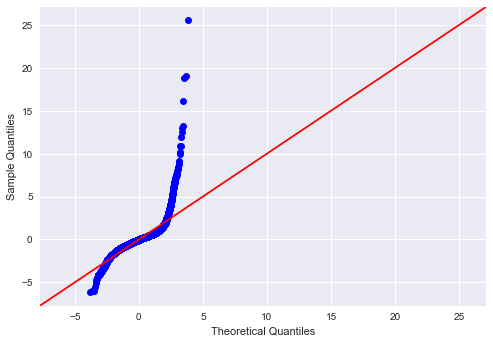

In [47]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

There are more errors as price increases. This needs to be refined so that the model is accurate. This model cannot be used without further refinement.

## Scatter Plot (Checking For Homoscedasticity)

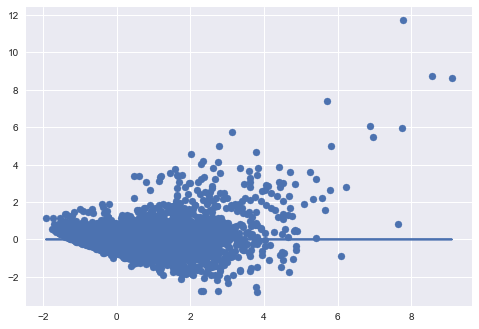

In [48]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

This plot is funnel-shaped. The errors show some correlation with price, so I need to refine this.

## Dealing with Outliers

I will now switch back to encoded_df so that I can see what the acutal price is, instead of the normalized price. I will drop the same columns that I dropped from df_norm so that both datasets contain the same base data.

In [49]:
encoded_df = encoded_df.drop(['sqft_living'], axis=1)
encoded_df.head(1)

,price,bedrooms,bathrooms,sqft_lot,grade,sqft_above,sqft_basement,floors_15,floors_20,floors_25,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
6,934000.0,9,3.0,4480,7,1880.0,940.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

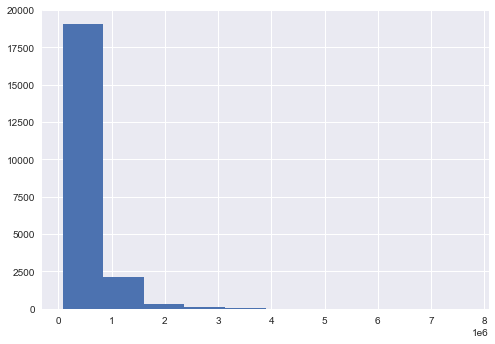

In [50]:
encoded_df.price.hist()

This is the same histogram that I checked before. Price is very skewed. I need to drop some of the outliers to see if I improve this distribution and make it more normalized.

### Checking price percentiles to find the outliers

In [51]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, encoded_df.price.quantile(q=q)))

0.8 percentile: 700500.0
0.81 percentile: 718000.0
0.82 percentile: 730000.8
0.83 percentile: 749950.0
0.84 percentile: 760003.0
0.85 percentile: 779665.0
0.86 percentile: 799000.0
0.87 percentile: 815000.0
0.88 percentile: 836600.0000000003
0.89 percentile: 859953.9999999999
0.9 percentile: 887000.0
0.91 percentile: 919986.0000000001
0.92 percentile: 950000.0
0.93 percentile: 997665.0000000007
0.94 percentile: 1060000.0
0.95 percentile: 1160000.0
0.96 percentile: 1260000.0
0.97 percentile: 1390000.0
0.98 percentile: 1600000.0
0.99 percentile: 1970000.0


In [52]:
for i in range(0,20):
    q = i/100
    print("{} percentile: {}".format(q, encoded_df.price.quantile(q=q)))

0.0 percentile: 78000.0
0.01 percentile: 154000.0
0.02 percentile: 175000.0
0.03 percentile: 192000.0
0.04 percentile: 202500.0
0.05 percentile: 210000.0
0.06 percentile: 219950.0
0.07 percentile: 226500.0
0.08 percentile: 234000.0
0.09 percentile: 240000.0
0.1 percentile: 245000.0
0.11 percentile: 250000.0
0.12 percentile: 255000.0
0.13 percentile: 260000.0
0.14 percentile: 266000.0
0.15 percentile: 270000.0
0.16 percentile: 275021.2
0.17 percentile: 280000.0
0.18 percentile: 286000.0
0.19 percentile: 291000.0


In [53]:
df = encoded_df

orig_tot = len(df)
df = df[df.price < 1500000]# Subsetting to remove extreme outliers
df = df[df.price > 125000]
print('Percent removed:', (orig_tot -len(df))/orig_tot)
train, test = train_test_split(df, random_state=23)

# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
final_model = ols(formula=formula, data=train).fit()
final_model.summary()


Percent removed: 0.028669352971145385


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     837.9
Date:                Wed, 22 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:52:33   Log-Likelihood:            -2.0439e+05
No. Observations:               15729   AIC:                         4.089e+05
Df Residuals:                   15647   BIC:                         4.096e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.769e+05   1.08e+04    -35.029      0.000   -3.98e+05   -3.56e+05
bedrooms      -1.025e+04   1290.174     -7.948      0.000   -1.28e+04   -7725.694
bathrooms      8715.3222   2012.814      4.330      0.000    4769.974    1.27e+04
sqft_lot          0.2986      0.024     12.540      0.000       0.252       0.345
grade          5.543e+04   1349.639     41.073      0.000    5.28e+04    5.81e+04
sqft_above      150.6924      2.327     64.767      0.000     146.132     155.253
sqft_basement   109.6914      2.788     39.350      0.000     104.227     115.155
floors_15      1.168e+04   3375.263      3.461      0.001    5065.638    1.83e+04
floors_20     -3.722e+04   2784.658    -13.368      0.000   -4.27e+04   -3.18e+04
floors_25     -6976.5151   1.11e+04     -0.626      0.531   -2.88e+04    1.49e+04
floors_30     -1.028e+05   6003.821    -17.129      0.000   -1.15e+05   -9.11e+04
floors_35     -1.471e+05    4.8e+04     -3.064      0.002   -2.41e+05    -5.3e+04
waterfront_10  3.825e+05   1.48e+04     25.763      0.000    3.53e+05    4.12e+05
zipcode_98002  2.163e+04    1.1e+04      1.974      0.048     146.720    4.31e+04
zipcode_98003 -1549.5097   9912.078     -0.156      0.876    -2.1e+04    1.79e+04
zipcode_98004  5.987e+05   1.07e+04     56.011      0.000    5.78e+05     6.2e+05
zipcode_98005  3.403e+05   1.17e+04     29.008      0.000    3.17e+05    3.63e+05
zipcode_98006  3.057e+05   8870.948     34.456      0.000    2.88e+05    3.23e+05
zipcode_98007   2.65e+05   1.21e+04     21.908      0.000    2.41e+05    2.89e+05
zipcode_98008  2.696e+05   9859.867     27.342      0.000     2.5e+05    2.89e+05
zipcode_98010   8.49e+04   1.44e+04      5.912      0.000    5.68e+04    1.13e+05
zipcode_98011  1.434e+05   1.08e+04     13.230      0.000    1.22e+05    1.65e+05
zipcode_98014  9.327e+04   1.32e+04      7.075      0.000    6.74e+04    1.19e+05
zipcode_98019  9.196e+04   1.12e+04      8.222      0.000       7e+04    1.14e+05
zipcode_98022  2.444e+04   1.06e+04      2.311      0.021    3715.333    4.52e+04
zipcode_98023 -2.394e+04   8546.654     -2.801      0.005   -4.07e+04   -7183.157
zipcode_98024  1.599e+05   1.56e+04     10.278      0.000    1.29e+05     1.9e+05
zipcode_98027  1.925e+05   9010.737     21.365      0.000    1.75e+05     2.1e+05
zipcode_98028  1.334e+05   9830.705     13.569      0.000    1.14e+05    1.53e+05
zipcode_98029  2.232e+05   9491.229     23.515      0.000    2.05e+05    2.42e+05
zipcode_98030  2007.2644   9903.560      0.203      0.839   -1.74e+04    2.14e+04
zipcode_98031  1.321e+04   9891.112      1.335      0.182   -6179.036    3.26e+04
zipcode_98032  3218.2801   1.29e+04      0.250      0.802    -2.2e+04    2.84e+04
zipcode_98033  3.681e+05   8991.183     40.945      0.000    3.51e+05    3.86e+05
zipcode_98034   1.94e+05   8404.268     23.086   

Model Analysis: Removing some of the price outliers on each end improved the model. (R-sqaured is now at 81%)
- This only removed 2.9% of the data, which is acceptable.

In [54]:
#making sure the changes are saved as final_df
final_df = df
final_df.head(1)

,price,bedrooms,bathrooms,sqft_lot,grade,sqft_above,sqft_basement,floors_15,floors_20,floors_25,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
6,934000.0,9,3.0,4480,7,1880.0,940.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

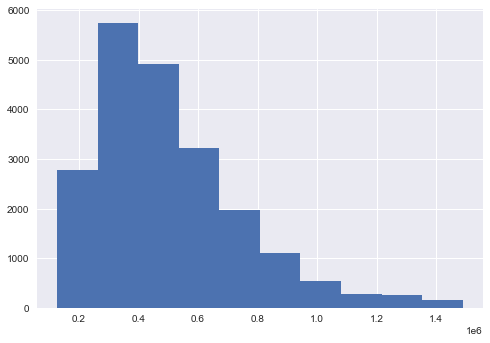

In [55]:
final_df.price.hist()

While this is not a normal distribution, it now looks more normalized than before. This is a good sign. I will see if this has done enough to help the model or if I need to refine further.

## Normalizing final_df and running model on it

In [56]:
final_df_norm = norm_feat(final_df)
final_df_norm.head(1)

,price,bedrooms,bathrooms,sqft_lot,grade,sqft_above,sqft_basement,floors_15,floors_20,floors_25,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
6,1.756998,6.379373,1.259494,-0.256734,-0.550632,0.176477,1.562765,-0.313701,1.289979,-0.079584,...,-0.11569,-0.051277,-0.146556,-0.109167,-0.110722,-0.108269,-0.111601,-0.080189,-0.11569,-0.121074


In [57]:
# Defining the problem
outcome = 'price'
x_cols = list(final_df_norm.columns)
x_cols.remove(outcome)
train, test = train_test_split(final_df_norm, random_state=23)
print(len(train), len(test))

15729 5243


In [58]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     837.9
Date:                Wed, 22 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:52:33   Log-Likelihood:                -9154.7
No. Observations:               15729   AIC:                         1.847e+04
Df Residuals:                   15647   BIC:                         1.910e+04
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0014      0.003     -0.407      0.684      -0.008       0.005
bedrooms         -0.0369      0.005     -7.948      0.000      -0.046      -0.028
bathrooms         0.0258      0.006      4.330      0.000       0.014       0.037
sqft_lot          0.0486      0.004     12.540      0.000       0.041       0.056
grade             0.2452      0.006     41.073      0.000       0.234       0.257
sqft_above        0.4656      0.007     64.767      0.000       0.452       0.480
sqft_basement     0.1886      0.005     39.350      0.000       0.179       0.198
floors_15         0.0136      0.004      3.461      0.001       0.006       0.021
floors_20        -0.0733      0.005    -13.368      0.000      -0.084      -0.063
floors_25        -0.0022      0.004     -0.626      0.531      -0.009       0.005
floors_30        -0.0692      0.004    -17.129      0.000      -0.077      -0.061
floors_35        -0.0101      0.003     -3.064      0.002      -0.017      -0.004
waterfront_10     0.0916      0.004     25.763      0.000       0.085       0.099
zipcode_98002     0.0084      0.004      1.974      0.048    5.71e-05       0.017
zipcode_98003    -0.0007      0.005     -0.156      0.876      -0.010       0.008
zipcode_98004     0.2396      0.004     56.011      0.000       0.231       0.248
zipcode_98005     0.1212      0.004     29.008      0.000       0.113       0.129
zipcode_98006     0.1823      0.005     34.456      0.000       0.172       0.193
zipcode_98007     0.0881      0.004     21.908      0.000       0.080       0.096
zipcode_98008     0.1245      0.005     27.342      0.000       0.116       0.133
zipcode_98010     0.0238      0.004      5.912      0.000       0.016       0.032
zipcode_98011     0.0560      0.004     13.230      0.000       0.048       0.064
zipcode_98014     0.0286      0.004      7.075      0.000       0.021       0.037
zipcode_98019     0.0354      0.004      8.222      0.000       0.027       0.044
zipcode_98022     0.0104      0.004      2.311      0.021       0.002       0.019
zipcode_98023    -0.0148      0.005     -2.801      0.005      -0.025      -0.004
zipcode_98024     0.0386      0.004     10.278      0.000       0.031       0.046
zipcode_98027     0.1076      0.005     21.365      0.000       0.098       0.118
zipcode_98028     0.0625      0.005     13.569      0.000       0.053       0.072
zipcode_98029     0.1109      0.005     23.515      0.000       0.102       0.120
zipcode_98030     0.0009      0.004      0.203      0.839      -0.008       0.010
zipcode_98031     0.0061      0.005      1.335      0.182      -0.003       0.015
zipcode_98032     0.0010      0.004      0.250      0.802      -0.007       0.009
zipcode_98033     0.2058      0.005     40.945      0.000       0.196       0.216
zipcode_98034     0.1243      0.005     23.086   

**Analysis:**
 - R-squared is above my target of 80%.
 - Prob(F-statistic) is still 0, so the model continues to have integrity on the test group.
 - Skew is significantly better at 0.971. It is still not 0, but this is only a 1/4 of the skew that the previous model was showing (3.961).
 - Kurtosis still exsists (7.45), but is also greatly improved over the previous model (63.337).

## Checking VIF and Assumptions Again
-  I will check VIF scores and assumptions one more time. If I don't see any red flags, I will keep this as my final model. 

In [59]:
x_cols = list(final_df_norm.columns)
x_cols.remove(outcome)

X = final_df_norm[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 1.7805132210413512),
 ('bathrooms', 2.90136926384536),
 ('sqft_lot', 1.2097440760169322),
 ('grade', 2.9362013916818963),
 ('sqft_above', 4.301815724624278),
 ('sqft_basement', 1.9071459760680587),
 ('floors_15', 1.281411310660798),
 ('floors_20', 2.487438131039225),
 ('floors_25', 1.0763573159929398),
 ('floors_30', 1.3639429100387757),
 ('floors_35', 1.0080770846340052),
 ('waterfront_10', 1.0665059472000828),
 ('zipcode_98002', 1.5367511066230723),
 ('zipcode_98003', 1.7691852321122818),
 ('zipcode_98004', 1.572515634881473),
 ('zipcode_98005', 1.4639703539655757),
 ('zipcode_98006', 2.307216204431571),
 ('zipcode_98007', 1.3938247627934675),
 ('zipcode_98008', 1.7618537995514445),
 ('zipcode_98010', 1.2831097810279246),
 ('zipcode_98011', 1.5380375619748208),
 ('zipcode_98014', 1.3579632145038398),
 ('zipcode_98019', 1.5286961745345073),
 ('zipcode_98022', 1.6672551082027045),
 ('zipcode_98023', 2.34007155951752),
 ('zipcode_98024', 1.2180257047769965),
 ('zipcode_980

**Analysis:**
- Sqft_Above has a VIF of 4.3. While I would like to see a lower score, it is less than my threshold of 7.
- All other VIFs are less than 3.

## Q-Q Plot (Normality Check)

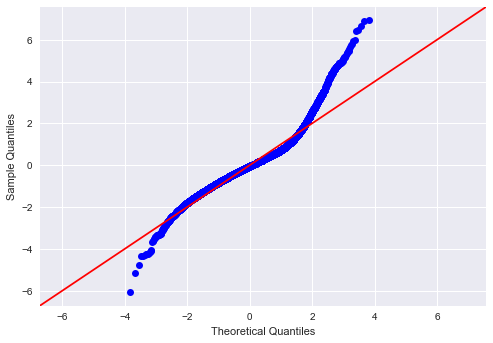

In [60]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

**Analysis:**
- Normality is definitely improved, but it still isn't ideal.
- However, for the scope of this business problem, my model will be accurate in determining the key factors in home value, so I am good to continue on and make my recommendations.
- **Note:** This model is still going to be unreliable on the extreme tails, so I would not trust it to predict an exact price for each feature. Fortunatley, that is beyond the scale of what I have been asked to do, so I am good to proceed.

## Scatter Plot (Homoscedasticity Check)

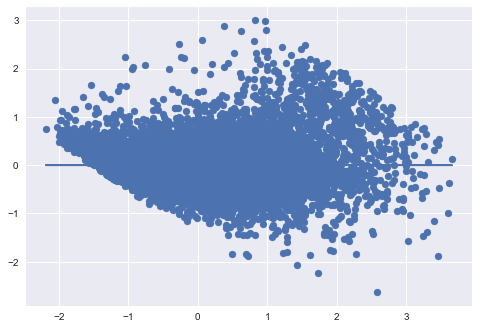

In [110]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

**Analysis:**
- The scatter plot has significantly improved, even though it is definitely not perfect.
- The extreme left tail is stll not showing a random distribution of errors.
- Like with the Q-Q Test, these results are not perfect, but they show the model is reliable enough for me to make reccomendations within the scope that was outlined in the business problem.

# Final Analysis and Recommendations

In [155]:
# Bringing up my model to analyze
results = ols(formula=formula, data=train).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     837.9
Date:                Wed, 22 Dec 2021   Prob (F-statistic):               0.00
Time:                        02:14:30   Log-Likelihood:                -9154.7
No. Observations:               15729   AIC:                         1.847e+04
Df Residuals:                   15647   BIC:                         1.910e+04
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0014      0.003     -0.407      0.684      -0.008       0.005
bedrooms         -0.0369      0.005     -7.948      0.000      -0.046      -0.028
bathrooms         0.0258      0.006      4.330      0.000       0.014       0.037
sqft_lot          0.0486      0.004     12.540      0.000       0.041       0.056
grade             0.2452      0.006     41.073      0.000       0.234       0.257
sqft_above        0.4656      0.007     64.767      0.000       0.452       0.480
sqft_basement     0.1886      0.005     39.350      0.000       0.179       0.198
floors_15         0.0136      0.004      3.461      0.001       0.006       0.021
floors_20        -0.0733      0.005    -13.368      0.000      -0.084      -0.063
floors_25        -0.0022      0.004     -0.626      0.531      -0.009       0.005
floors_30        -0.0692      0.004    -17.129      0.000      -0.077      -0.061
floors_35        -0.0101      0.003     -3.064      0.002      -0.017      -0.004
waterfront_10     0.0916      0.004     25.763      0.000       0.085       0.099
zipcode_98002     0.0084      0.004      1.974      0.048    5.71e-05       0.017
zipcode_98003    -0.0007      0.005     -0.156      0.876      -0.010       0.008
zipcode_98004     0.2396      0.004     56.011      0.000       0.231       0.248
zipcode_98005     0.1212      0.004     29.008      0.000       0.113       0.129
zipcode_98006     0.1823      0.005     34.456      0.000       0.172       0.193
zipcode_98007     0.0881      0.004     21.908      0.000       0.080       0.096
zipcode_98008     0.1245      0.005     27.342      0.000       0.116       0.133
zipcode_98010     0.0238      0.004      5.912      0.000       0.016       0.032
zipcode_98011     0.0560      0.004     13.230      0.000       0.048       0.064
zipcode_98014     0.0286      0.004      7.075      0.000       0.021       0.037
zipcode_98019     0.0354      0.004      8.222      0.000       0.027       0.044
zipcode_98022     0.0104      0.004      2.311      0.021       0.002       0.019
zipcode_98023    -0.0148      0.005     -2.801      0.005      -0.025      -0.004
zipcode_98024     0.0386      0.004     10.278      0.000       0.031       0.046
zipcode_98027     0.1076      0.005     21.365      0.000       0.098       0.118
zipcode_98028     0.0625      0.005     13.569      0.000       0.053       0.072
zipcode_98029     0.1109      0.005     23.515      0.000       0.102       0.120
zipcode_98030     0.0009      0.004      0.203      0.839      -0.008       0.010
zipcode_98031     0.0061      0.005      1.335      0.182      -0.003       0.015
zipcode_98032     0.0010      0.004      0.250      0.802      -0.007       0.009
zipcode_98033     0.2058      0.005     40.945      0.000       0.196       0.216
zipcode_98034     0.1243      0.005     23.086   

## Ranking Features using Coefficients

In [156]:
#Checking coefficients
coeff = results.params
ranked_features = coeff.sort_values(ascending=False)
ranked_features

sqft_above       0.47
grade            0.25
zipcode_98004    0.24
zipcode_98103    0.24
zipcode_98115    0.23
zipcode_98117    0.22
zipcode_98112    0.21
zipcode_98033    0.21
zipcode_98040    0.20
zipcode_98199    0.20
sqft_basement    0.19
zipcode_98105    0.19
zipcode_98006    0.18
zipcode_98116    0.17
zipcode_98052    0.17
zipcode_98119    0.17
zipcode_98122    0.16
zipcode_98107    0.16
zipcode_98144    0.14
zipcode_98109    0.13
zipcode_98136    0.13
zipcode_98008    0.12
zipcode_98034    0.12
zipcode_98102    0.12
zipcode_98053    0.12
zipcode_98005    0.12
zipcode_98075    0.12
zipcode_98125    0.12
zipcode_98074    0.12
zipcode_98118    0.11
zipcode_98126    0.11
zipcode_98029    0.11
zipcode_98177    0.11
zipcode_98027    0.11
zipcode_98133    0.10
waterfront_10    0.09
zipcode_98007    0.09
zipcode_98155    0.09
zipcode_98039    0.08
zipcode_98072    0.08
zipcode_98106    0.07
zipcode_98056    0.07
zipcode_98077    0.06
zipcode_98059    0.06
zipcode_98146    0.06
zipcode_98

In [157]:
ranked_features = ranked_features.reset_index()
ranked_features = ranked_features.rename(columns={"index": "zipcode"})
ranked_features = ranked_features.reset_index()
ranked_features = ranked_features.rename(columns={"index": "rank"})
ranked_zip = ranked_features.drop(labels=[0,1,10,35,50,57,64,74,75,77,79,80,81,], axis=0)
ranked_zip = ranked_zip.drop('rank', axis=1)
ranked_zip = ranked_zip.reset_index()
ranked_zip = ranked_zip.drop('index', axis=1)
ranked_zip = ranked_zip.reset_index()
franked_zip = ranked_zip.rename(columns={"index": "rank"})
ranked_zip

,index,zipcode,0
0,0,zipcode_98004,0.24
1,1,zipcode_98103,0.24
2,2,zipcode_98115,0.23
3,3,zipcode_98117,0.22
4,4,zipcode_98112,0.21
5,5,zipcode_98033,0.21
6,6,zipcode_98040,0.20
7,7,zipcode_98199,0.20
8,8,zipcode_98105,0.19
9,9,zipcode_98006,0.18


**Analysis:**
 - Sqft_above is the most impactful feature in regards to the price of a home in King County, with a coefficient of .4656 and the highest t statistic (64.77)
 - grade is the second most impactful feature with coefficient of .2452, and t statistic near 42 (however, the majority of the data has a grade of 3 = 'average'.
 - basement is #3 with coefficient of .1886 and t statistic of aproximately 40.

 **In terms of Location:**
- being on the waterfront increases the value of your house, but not as much as actual features of the house.
- Zip Code plays a huge rule in value. Different Zip Codes have different values, but the highest one have coefficents and t statistics that would place them in betwen grade and sqft_basement in importance.
- the lowest value Zip Codes don't affect price very much (a couple even have a negative coefficient), but the majority make a statistically relevant difference.

**Other Features:**
 - sqft_lot. coefficient = .048, t-statistic = 12.54
 - bathrooms = coefficent = .025, t-statistic = 4.33
 - bedrooms & floors have NEGATIVE coefficients

## Questions to Answer - Revisited

### Question 1: What features have the biggest effect on home price?
1. Size of House (excluding Basement).
2. Grade
3. Location (Zip Code) 
4. Size of Basement
5. Waterfront Location
6. Size of Lot
7. Number of Bathrooms

### Question 2:  Are these features able to be changed/renovated, or are they fixed?
- Features that CAN be changed (even if difficult):
    1. Size of House
    2. Grade
    3. Basement Size -- I assume that this would be difficult, but not impossible.
    4. Additional Bathrooms

### Question 3: What are the best features that Trailblazer Renovations should market to potential clients?
1. Home Size
2. Grade (?)
3. Basement Size
4. Bathrooms

### Question 4: Who should Trailblazer target their m arketing campaign toward?
- Customers in Zip Codes that had high coefficients in my model.

### Question 5:  Are there any features that Trailblazer recommend against?
- Extra Bedrooms
- Extra Floors

These features have a negative coefficient in regards to home price. If the client **needs** these features, then that is fine. But the scope of my analysis was to find the features that maximized home value and these two features do not meet that metric.


# Recommendations

### Visualization: Regplot of Home Price vs. Square Footage

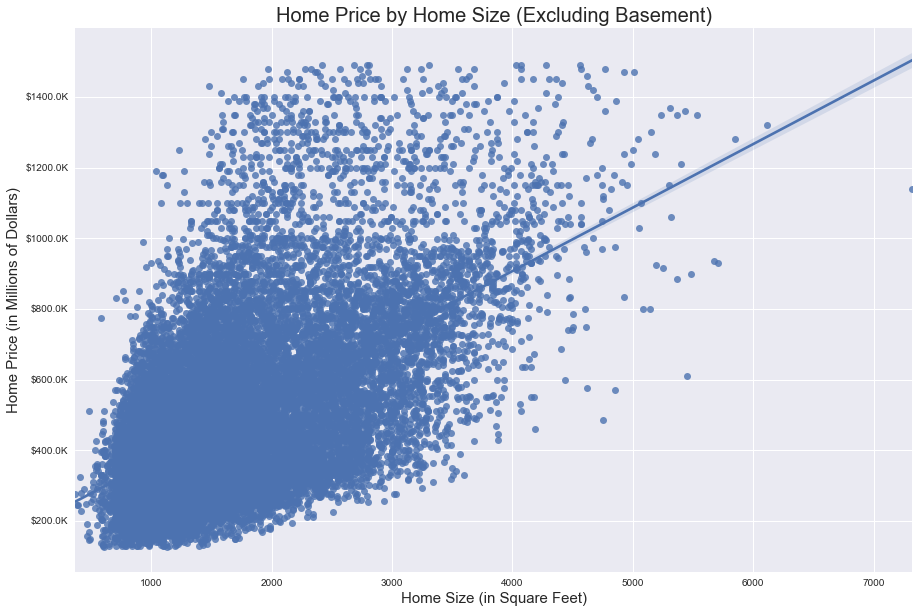

In [163]:
fig, ax = plt.subplots(figsize=(15,10))
 
p =sns.regplot('sqft_above','price', data=final_df);

plt.title('Home Price by Home Size (Excluding Basement)', fontsize=20)# Set Title

plt.xlabel('Home Size (in Square Feet)', fontsize=15)# Set x-axis label

plt.ylabel('Home Price (in Millions of Dollars)', fontsize=15)# Set y-axis label
p.yaxis.set_major_formatter(display_thousands)

plt.savefig('images/home_price_by_home_size')

plt.show();



## Recommendation #1

Trailblazer Renovations should focus on home additions. <b>Increasing the square footage of the home has the greatest effect on the value of the house.</b> This is advice that can be given to any homeowner whereever they live in King County. 
- The increased square footage should be used for common areas as additional bedrooms have a negative corellation with price. 
- Extra floors should also be avoided, as floors have a negative corellation with price.
- The exception to this is in the basement. Theoretically, if you are able to increase the space in your basement (perhaps converting mechanical closets/storage into common space), there is value to be added there.
    - I know that it is possible to even add a basement to a house that didn't initially have one, but I also know that it's signficantly more expensive to do that.

## Recommendation #2

Trailblazer Renovations Inc. should use targeted marketing to homeowners in certain zip codes within King County. **There is a high coefficient on many zip codes, especially in the Seattle municipal area.**

Assuming that the cost for labor and materials is the same no matter what zip code the house is located in, the same work with the same materials brings greater value in certain zip codes.

Use the following list as a ranking of where to prioritize marketing efforts.

In [159]:
ranked_zip

,index,zipcode,0
0,0,zipcode_98004,0.24
1,1,zipcode_98103,0.24
2,2,zipcode_98115,0.23
3,3,zipcode_98117,0.22
4,4,zipcode_98112,0.21
5,5,zipcode_98033,0.21
6,6,zipcode_98040,0.20
7,7,zipcode_98199,0.20
8,8,zipcode_98105,0.19
9,9,zipcode_98006,0.18


### Visualization: Regplot of Home Price vs. Grade

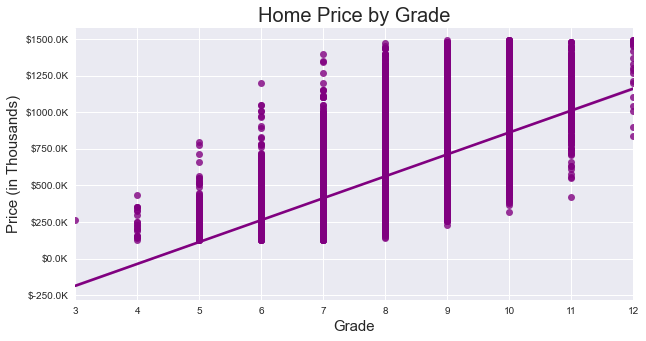

In [162]:
#plotting grade vs price

fig, ax = plt.subplots(figsize=(10,5))

p = sns.regplot(x="grade", y="price", data=final_df, label="grade", color='purple')

p.set_xlabel("Grade", fontsize = 15)
p.set_ylabel("Price (in Thousands)", fontsize = 15)
p.yaxis.set_major_formatter(display_thousands)

p.set_title("Home Price by Grade", fontsize = 20)
plt.figsize=(15,10) 
plt.savefig('images/home_price_by_grade')

plt.show();

## Recommendation #3
The second most signicant corellation for Home Price is Building Grade. I recommend that all renovations and additions done by TrailBlazer be done to the highest level of quality in terms of both materials and workmanship. If the renovations can cause the house to increase in grade, it will improbe the value of the house.

Most houses fall in the 7-8 grade. (71% of the records in the dataset). This is considered "Average" to "Just Above Average". Level 9 cites "better architectural design with extra interior and exterior design and quality."

The more unique and custom the features of the addtion are, the more that it will add value to the home.


# Summary
I was tasked with analyzing home prices in King County to determine where the market for home renovations exists. Spefically, I was to determine which renovation types have the biggest increase in home value so that those services can be the focus of their marketing campaign.

I used the data provided and after cleaning and pre-processing, was able to develop a model which showed the effect that various features had on the price of homes.

My recommendation is that Trailblazer Renovations Inc. focus on features that add to the size of existing homes (ie Additions). These additions should be additional shared areas such as bathrooms,  as extra bedrooms begin to have a negative correlation with home value. I also recommend that the additions be on existing floors of the house, as additional floors also begin to have a negative correlation.

I also recommend that these additions be done with the highest quality materials and to the highest standard as the Grade of the home is also a strong contributor to home value. The more unique and custom the features of the addtion are, the more that it will add value to the home.

As for marketing, my model determined that the location of houses played a major role in their value. Therefore, Trailblazer Inc. should focus on the zip codes with the highest coefficients from the final model. I provided a ranked list for them to use for this purpose. 
